# Tobig's 19기 2주차 Optimization 과제

# Gradient Descent 구현하기

### 1)"..."표시되어 있는 빈 칸을 채워주세요
### 2)강의내용과 코드에 대해 공부한 내용을 마크마운 또는 주석으로 설명해주세요

## 데이터

In [10]:
import pandas as pd
import numpy as np
import random

In [11]:
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


## Train Test 데이터 나누기

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size = 0.25, random_state = 0)

# train data =75%, test data = 25%
# random_state = 0 : 수행할 때마다 동일한 데이터 생성, 설정하지 않으면 수행할 때마다 다른 데이터를 생성한다.

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

## Scaling

experience와 salary의 단위, 평균, 분산이 크게 차이나므로 scaler를 사용해 단위를 맞춰줍니다. 

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]    #bias collum과 index 유지
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


이때 scaler는 X_train에 fit 해주시고, fit한 scaler를 X_test에 적용시켜줍니다.  
똑같이 X_test에다 fit하면 안돼요!

In [16]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


In [17]:
# parameter 개수
N = len(X_train.loc[0])

In [18]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
random_parameters = parameters.copy()
parameters

array([0.9996911 , 0.94014585, 0.67107508])

### * LaTeX   

Jupyter Notebook은 LaTeX 문법으로 수식 입력을 지원하고 있습니다.  
LaTeX문법으로 아래의 수식을 완성해주세요  
http://triki.net/apps/3466  
https://jjycjnmath.tistory.com/117

## Dot product
## $z = X_i \theta$

In [20]:
def dot_product(X, parameters):
    z = 0
    for i in range(len(parameters)):
        z += X[i] * parameters[i]
    return z

## Logistic Function

## $p = \frac{1}{1 + e^{-x_{i}\theta}}$

In [21]:
def logistic(X, parameters):
    z = dot_product(X,parameters)
    p = 1/(1+np.exp(-z))
    return p

In [22]:
logistic(X_train.iloc[1], parameters)

0.8950876156684271

## Object function

Object Function : 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수입니다.  
<br>
선형 회귀의 목적함수
## $l(\theta) = \frac{1}{2}\Sigma(y_i - \theta^{T}X_i)^2$  
참고) $\hat{y_i} = \theta^{T}X_i$
  
로지스틱 회귀의 목적함수를 작성해주세요  
(선형 회귀의 목적함수처럼 강의에 나온대로 작성해주세요. 평균을 고려하는 것은 뒤에 코드에서 수행합니다)
## $l(p) = - \Sigma(y_{i}\log p(X_{i}) + (1 - y_{i}) \log(1 - p(X_{i}))) $ 

In [23]:
def minus_log_cross_entropy_i(X, y, parameters):
    p = logistic(X, parameters)
    loss = (y * np.log(p) + (1 - y) * np.log(1-p))
    return -loss

In [24]:
def mse_i(X, y, parameters):
    y_hat = np.dot(X ,parameters.T)
    loss = ((y - y_hat)**2) / 2
    return loss

In [25]:
def batch_loss(X_set, y_set, parameters, loss_function, n): #n:현재 배치의 데이터 수
    loss = 0
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        loss += loss_function(X, y, parameters)
    loss = loss / n #loss 평균값으로 계산
    return loss

In [26]:
batch_loss(X_test, y_test, parameters, minus_log_cross_entropy_i, len(X_test))

1.5763507639455618

## Gradient
위의 선형회귀의 목적함수 $l(\theta)$와 로지스틱회귀의 목적함수 $l(p)$의 gradient를 작성해주세요  
(위의 목적함수를 참고해서 작성해주세요 = 평균을 고려하는 것은 뒤에 코드에서 수행합니다)

## ${\partial\over{\partial \theta_j}}l(\theta)=$ $ -\Sigma(y_{i} - \theta^{T}X_{i})X_{ij} $
## ${\partial\over{\partial \theta_j}}l(p)=$ $ -\Sigma(y_{i} - p_{i})X_{ij} $

In [27]:
def get_gradient_ij(X, y, parameters, j, model):
    if model == 'linear':
        y_hat = np.dot(X, parameters.T)
        gradient = (y - y_hat) * X[j]
    else:
        p = logistic(X, parameters)
        gradient = (y - p) * X[j]
    return -gradient

In [28]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'logistic')

-0.0749945183132031

$ \alpha^2 $

## Batch Gradient
하나의 배치 (X_set, y_set)에 대해 기울기를 구하는 코드를 작성해주세요

In [30]:
def batch_gradient(X_set, y_set, parameters, model):
    gradients = [0 for _ in range(len(parameters))]
    
    for i in range(len(X_set)):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        for j in range(len(parameters)):
            gradients[j] += get_gradient_ij(X, y, parameters, j, model)
    
    return gradients

In [31]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'logistic')
gradients1

[57.07820843910687, 17.474722772549168, 46.82491530117679]

## mini-batch
인덱스로 미니 배치 나누기

In [32]:
def batch_idx(X_train, batch_size):
    N = len(X_train)
    nb = (N // batch_size)+1 #number of batch
    idx = np.array([i for i in range(N)])
    idx_list = [idx[i*batch_size:(i+1)*batch_size] for i in range(nb) if len(idx[i*batch_size:(i+1)*batch_size]) != 0]
    return idx_list

batch_idx 함수에 대한 설명을 batch_size와 함께 간략하게 작성해주세요  
### 설명: batch_size는 학습에 사용되는 데이터의 크기를 의미한다. batch_size가 X_train의 크기와 같다면 X_train 전체를 한번의 학습에 사용한다는 의미이다. 

## Update Parameters
기울기를 갱신하는 코드를 작성해주세요  
(loss와 마찬가지로 기울기를 갱신할 때 배치 사이즈를 고려해 평균으로 갱신해주세요)

In [ ]:
def step(parameters, gradients, learning_rate, n): #n:현재 배치의 데이터 수
    for i in range(len(parameters)):
        gradients[i] *= learning_rate / n
    
    parameters -= gradients
    return parameters

In [ ]:
step(parameters, gradients1, 0.01, len(X_train))

## Gradient Descent
위에서 작성한 함수들을 조합해서 경사하강법 함수를 완성해주세요

- learning_rate: 학습률  
- tolerance: Step이 너무 작아서 더 이상의 학습이 무의미할 때 학습을 멈추는 조건  
- batch: 기울기를 1번 갱신할 때 사용하는 데이터셋  
- epoch:  현재 반복 횟수
- num_epoch: 총 학습 횟수
<br>

BGD: 모든 데이터셋의 기울기를 학습 한번에 구함 <br>
SGD: 임의의 1개의 데이터에 대해서 한번의 학습동안 기울기를 구함 <br>
MGD: 데이터셋의 일부에 대해서 학습 한번 동안 기울기를 구함
<br>

batch_size에 따른 경사하강법의 종류를 적어주세요  
batch_size=1 -> SGD  
batch_size=k -> MGD 
<br>
batch_size=whole -> BGD 

In [ ]:
def gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 16):
    stopper = False
    
    N = len(X_train.iloc[0])
    parameters = np.random.rand(N)    #train_data의 독립변수의 수만큼 랜덤한 파라미터 설정 
    
    #로지스틱 회귀는 목적함수로 minus_log_cross_entropy_i, 선형회귀는 mse_i
    if model == 'logistic':
        loss_function = minus_log_cross_entropy_i 
    else:
        loss_function = mse_i
    loss = 999
    batch_idx_list = batch_idx(X_train, batch_size)
    
    for epoch in range(num_epoch):
        if stopper:
            break
        for idx in batch_idx_list:
            X_batch = X_train.iloc[idx,]
            y_batch = y_train.iloc[idx]
            gradients = batch_gradient(X_batch, y_batch, parameters, model)
            parameters = step(parameters, gradients, learning_rate, len(X_batch))
            new_loss = batch_loss(X_batch, y_batch, parameters, loss_function, len(X_batch))
            
            #중단 조건             
            # 새로운 손실 함수와 기존 손실함수의 차이가 tolerance보다 작다면 학습을 중단
            if abs(new_loss - loss) < tolerance:
                stopper = True
                break
            loss = new_loss
        
        #100epoch마다 학습 상태 출력
        if epoch%100 == 0: #출력이 길게 나오면 check point를 수정해도 됩니다.
            print(f"epoch: {epoch}  loss: {new_loss}  params: {parameters}  gradients: {gradients}")
    
    return parameters

## Implement
경사하강법 함수를 이용해 최적의 모수 찾아보세요. 학습을 진행할 때, Hyper Parameter를 바꿔가면서 학습시켜보세요.

## Logistic Regression

In [ ]:
new_param_bgd = gradient_descent(X_train, y_train, batch_size = X_train.shape[0])
new_param_bgd

In [ ]:
new_param_sgd = gradient_descent(X_train, y_train, batch_size = 1)
new_param_sgd

In [ ]:
new_param_mgd = gradient_descent(X_train, y_train, batch_size = 32)
new_param_mgd

### Predict Label

In [ ]:
# BGD 활용 예측
y_predict = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_bgd)
    if p> 0.5 :
        y_predict.append(1)
    else :
        y_predict.append(0)
        
#초기 설정한 random_parameter로 예측
        y_predict_random = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], random_parameters)
    if p> 0.5 :
        y_predict_random.append(1)
    else :
        y_predict_random.append(0)

### Confusion Matrix

In [ ]:
from sklearn.metrics import *

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
confusion_matrix(y_test, y_predict)

In [ ]:
accuracy = (tp+tn) / (tp+fn+fp+tn)
print("accuracy:",accuracy)

## Linear regression
### $y = 0.5 + 2.7x$

### Data

In [ ]:
raw_X = np.random.rand(150)
y = 2.7*raw_X + 0.5 + np.random.randn(150)

In [ ]:
tmp = np.array([1 for _ in range(150)])
X = np.vstack((tmp, raw_X)).T
X = pd.DataFrame(X)
y = pd.Series(y)

### Estimation

In [ ]:
#정규방정식
theta = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
theta

In [ ]:
#경사하강법
new_param = gradient_descent(X, y, model = 'linear')
new_param

In [50]:
y_hat_NE = theta.dot(X.T)
y_hat_GD = new_param.dot(X.T)

### Visualization
시각화를 통해 정규방정식과 경사하강법을 통한 선형회귀를 비교해보세요  
(밑의 코드를 실행만 시키면 됩니다. 추가 코드 x)

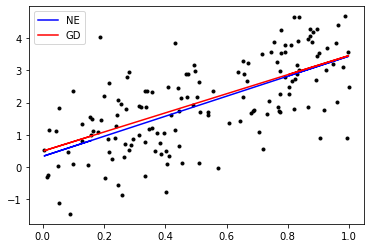

In [51]:
import matplotlib.pyplot as plt
plt.plot(X.iloc[:,1], y, '.k') #산점도
plt.plot(X.iloc[:,1], y_hat_NE, '-b', label = 'NE') #정규방정식
plt.plot(X.iloc[:,1], y_hat_GD, '-r', label = 'GD') #경사하강법
plt.legend()
plt.show()